In [123]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import utils
from sklearn.preprocessing import StandardScaler
import scorecardpy as sc
import re
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score


application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

# drop columns
data_full.drop(columns=['SELLER NAME', 'SERVICER NAME','DEFECT SETTLEMENT DATE', 'ZERO BALANCE EFFECTIVE DATE','DUE DATE OF LAST PAID INSTALLMENT (DDLPI)',
 'MI RECOVERIES', 'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES', 'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS', 'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES', 'ACTUAL LOSS CALCULATION',
 'POSTAL CODE', 'ZERO BALANCE REMOVAL UPB', 'PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER', 'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION',
 'FIRST PAYMENT DATE', 'MATURITY DATE'], inplace=True)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)

# change these columns to category 
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype('category')
data_full['ZERO BALANCE CODE'] = data_full['ZERO BALANCE CODE'].astype('category')
data_full['PROPERTY VALUATION METHOD'] = data_full['PROPERTY VALUATION METHOD'].astype('category')

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0).astype(int)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# turn into dummy variables
data_full = pd.get_dummies(data_full, columns=['MODIFICATION FLAG', 'ZERO BALANCE CODE', 
                                               'STEP MODIFICATION FLAG', 'PAYMENT DEFERRAL', 'DELINQUENCY DUE TO DISASTER', 
                                               'BORROWER ASSISTANCE STATUS CODE', 'FIRST TIME HOMEBUYER FLAG', 'OCCUPANCY STATUS', 
                                               'CHANNEL', 'PREPAYMENT PENALTY MORTGAGE (PPM) FLAG', 'AMORTIZATION TYPE', 'PROPERTY STATE', 
                                               'PROPERTY TYPE', 'LOAN PURPOSE', 'SUPER CONFORMING FLAG', 
                                               'PROGRAM INDICATOR', 'RELIEF REFINANCE INDICATOR', 'INTEREST ONLY INDICATOR (I/O INDICATOR)', 
                                               'MI CANCELLATION INDICATOR', 'PROPERTY VALUATION METHOD'], drop_first=True, dummy_na=True)

# drop credit score nulls only 40ish obs
data_full = data_full[~(data_full['CREDIT SCORE'].isnull())]

# drop DEFAULT column
data_full.drop(columns=['DEFAULT','DEFAULT CUM SUM'], inplace=True)

############# train test oot split ################

# the date for this is different than Q1 we make PD for every month not in oot
# make data 
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2023-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2024-06-01']

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12'])
y = data_full_train['DEFAULT_NEXT_12']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.5,  random_state=42)

# save the loan sequence numbers to use later
x_train_loan_seq = X_train['LOAN SEQUENCE NUMBER']
x_test_loan_seq = X_test['LOAN SEQUENCE NUMBER']

# save the monthly reporting period to use later
x_train_monthly_reporting_period = X_train['MONTHLY REPORTING PERIOD']
x_test_monthly_reporting_period = X_test['MONTHLY REPORTING PERIOD']

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER','MONTHLY REPORTING PERIOD'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER', 'MONTHLY REPORTING PERIOD'], inplace=True)

# combine the train and test data
X_train['DEFAULT_NEXT_12'] = y_train
X_test['DEFAULT_NEXT_12'] = y_test

In [124]:
# get ordered and unordered variables
X_train_ordered, X_train_unordered = utils.split_dataframe_by_columns(X_train)
X_test_ordered, X_test_unordered = utils.split_dataframe_by_columns(X_test)
oot_ordered, oot_unordered = utils.split_dataframe_by_columns(data_full_oot)

# combine the train and test data
X_train_ordered['DEFAULT_NEXT_12'] = y_train.astype(int)
X_test_ordered['DEFAULT_NEXT_12'] = y_test

import pickle
# import pkl files
with open('model.pkl', 'rb') as f:
    model_dict = pickle.load(f)
bins_adj = model_dict['bins_adj']
model = model_dict['model']

train_woe = sc.woebin_ply(X_train_ordered, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_ordered, bins_adj) # Calculate WoE dataset (test)


######### add unordered variables back to the train and test set #########
X_train_model = pd.concat([train_woe, X_train_unordered], axis=1)
X_test_model = pd.concat([test_woe, X_test_unordered], axis=1)

X_train_model = X_train_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_train_model = train_woe['DEFAULT_NEXT_12']

X_test_model = X_test_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_test_model = test_woe['DEFAULT_NEXT_12']

# reoder the columns for each dataset
X_train_model = X_train_model[model.feature_names_in_]
X_test_model = X_test_model[model.feature_names_in_]

# get AUC on train set
y_train_pred = model.predict_proba(X_train_model)[:,1]
auc_train = roc_auc_score(y_train_model, y_train_pred)
print(f" AUC on train set: {auc_train:.4f}")

# get auc on test set
y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")

[INFO] converting into woe values ...
Woe transformating on 558163 rows and 20 columns in 00:00:26
[INFO] converting into woe values ...
Woe transformating on 558445 rows and 20 columns in 00:00:23
 AUC on train set: 0.8588
 AUC on test set: 0.8575


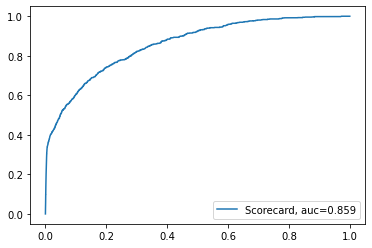

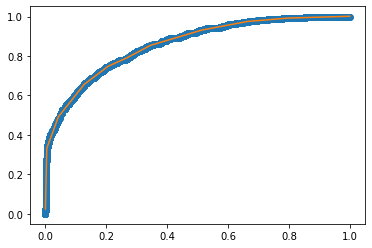

In [55]:
# create auc curve for the logistic regression model 
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_model, y_test_pred)

# Correct the infinite threshold
thresholds[0] = 1

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test_model,
                             y_score = y_test_pred),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

import pwlf
# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

# Calculate the best curve. Long!
nr_cuts = 10
res = piecewise_AUC.fitfast(nr_cuts, pop=2)

ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

# Apply cuts!
cuts = piecewise_AUC.fit_with_breaks(res)

# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [ ]:
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Add a new column for the true rate
PDs_Tab['Default Rate'] = PDs_Tab[True] / (PDs_Tab[True] + PDs_Tab[False])


In [125]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
  # Get how far the fpr is from each ROC curve fpr point.
  temp = np.abs(np.round(ROC_curve.fpr, 2) - np.round(fpr, 2))

  # Get the index of the smallest value
  idx = np.argmin(temp)

  # Get the threshold associated with that point
  pbb_cuts[i] = ROC_curve.threshold[idx]
  i += 1

# Reverse to correctly sort
pbb_cuts = np.flip(pbb_cuts)
pbb_cuts

# Add 0 (and one) if not present. 1 is found, so we don't need to adjust it.
pbb_cuts = np.insert(pbb_cuts, 0, 0)

# Get unique values
pbb_cuts = np.unique(pbb_cuts)

# Display the result
pbb_cuts

pd_cut = pd.cut(y_test_pred, pbb_cuts)
pd_cut

# Add the PDCut variable to our dataframe
PD_cut = pd.Series('PD_Cut', pd.cut(y_test_pred, pbb_cuts).astype(str))

loans = pd.DataFrame({'Default' : y_test_model, 'Portfolio' : x_test_loan_seq, 'PD_cut' : PD_cut.index, 'Probs': y_test_pred, 'Period': x_test_monthly_reporting_period})

# Create pivot table
PD_monthly = pd.pivot_table(loans,
                            values = 'Default',
                            index = 'Period',
                            columns = 'PD_cut',
                            aggfunc = 'mean'
                            )

PD_monthly

PD_cut,"(0.0, 0.108]","(0.108, 0.229]","(0.229, 0.277]","(0.277, 0.338]","(0.338, 0.414]","(0.414, 0.456]","(0.456, 0.487]","(0.487, 0.546]","(0.546, 0.66]","(0.66, 1.0]"
Period,,,,,,,,,,
2021-01-01,0.0,0.001040,0.004875,0.003107,0.004058,0.012075,0.012702,0.008708,0.027809,0.152245
2021-02-01,0.0,0.000647,0.003573,0.002168,0.004353,0.009826,0.012746,0.007413,0.023474,0.140177
2021-03-01,0.0,0.000301,0.002990,0.002120,0.005376,0.009077,0.010477,0.012158,0.024924,0.128297
2021-04-01,0.0,0.000558,0.002836,0.002023,0.004887,0.010622,0.010563,0.013878,0.024164,0.114103
2021-05-01,0.0,0.000808,0.001828,0.001983,0.004809,0.009774,0.011765,0.013250,0.021370,0.110246
2021-06-01,0.0,0.000791,0.000892,0.002722,0.005455,0.007424,0.010502,0.012298,0.023871,0.106061
2021-07-01,0.0,0.000768,0.000860,0.003012,0.006645,0.008148,0.010477,0.015072,0.020065,0.105644
2021-08-01,0.0,0.000755,0.000836,0.002947,0.005879,0.008088,0.011403,0.014126,0.022164,0.110949
2021-09-01,0.0,0.000738,0.000819,0.003613,0.006043,0.008734,0.014925,0.016153,0.021094,0.120120


## Economic Factors

In [131]:
# import df 
# Load the CSV file
fred_df = pd.read_csv('current.csv')

# Drop the first row
fred_df = fred_df.iloc[1:]

# Convert 'sasdate' column to datetime
fred_df['sasdate'] = pd.to_datetime(fred_df['sasdate'])

# Filter rows between 2021-06-01 and 2024-06-01 (inclusive)
filtered_df = fred_df[
    (fred_df['sasdate'] >= '2021-06-01') & 
    (fred_df['sasdate'] <= '2023-10-01')
]
filtered_df.drop(columns=['sasdate'], inplace=True)

# standardize economic factors
scaler = StandardScaler()
# Select the columns to standardize
columns_to_standardize = ['CPIAUCSL', 'REALLN', 'HOUST', 'UNRATE', 'DPCERA3M086SBEA']
# Standardize the selected columns
filtered_df[columns_to_standardize] = scaler.fit_transform(filtered_df[columns_to_standardize])

# Optional: Reset index
filtered_df = filtered_df.reset_index(drop=True)

# Filter DataFrame to keep only the selected columns
econ_factors = filtered_df[columns_to_standardize]

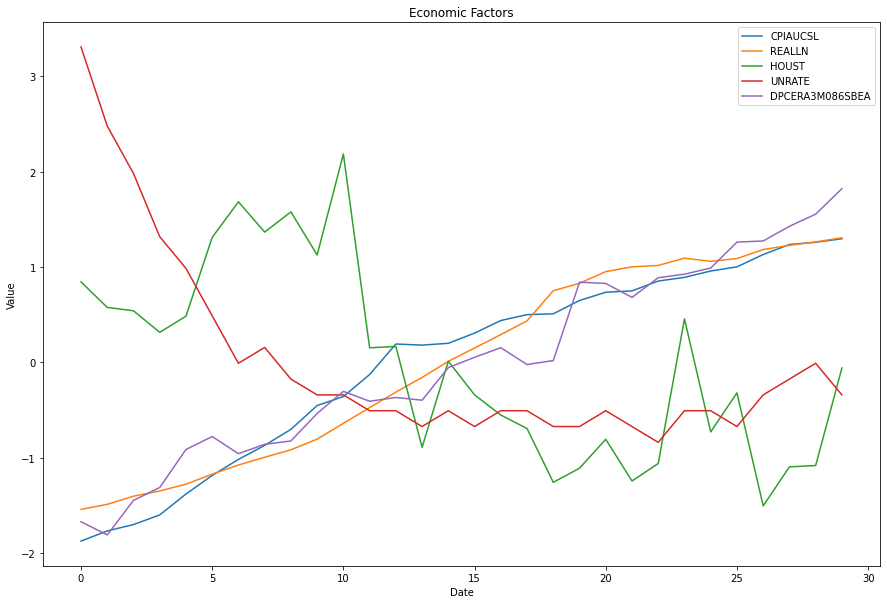

In [128]:
# see trend for the economic factors
econ_factors.plot(figsize=(15, 10))
plt.title('Economic Factors')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_standardize)
plt.show()

In [129]:
len(PD_monthly)

29

In [132]:
len(econ_factors)

29

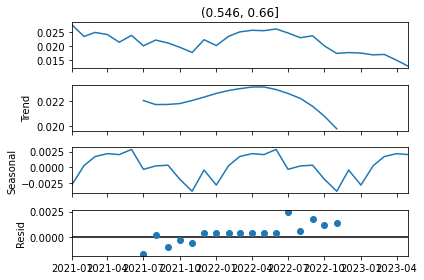

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

decomposition = seasonal_decompose(PD_monthly.iloc[:, 8], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, 6] # Choose the fifth rating

aic_out = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factors),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=True,
                    enforce_invertibility=False
                    )
      results = mod.fit(verbose=False)
      aic_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

# Nicer formatting
aic_out = pd.DataFrame(aic_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97553D+00    |proj g|=  1.51355D+02

At iterate    5    f= -5.04917D+00    |proj g|=  1.59806D+01

At iterate   10    f= -5.06471D+00    |proj g|=  4.14850D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     35      1     0     0   1.057D+00  -5.066D+00
  F =  -5.0656636459653379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-279.8084914659896
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34666D+00    |proj g|=  3.37259D+02


 This problem is unconstrained.



At iterate    5    f= -4.52456D+00    |proj g|=  1.77710D+01

At iterate   10    f= -4.54682D+00    |proj g|=  1.54984D+01

At iterate   15    f= -4.54965D+00    |proj g|=  5.37153D+00

At iterate   20    f= -4.55037D+00    |proj g|=  1.99435D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     45      1     0     0   6.526D-01  -4.550D+00
  F =  -4.5504060971945526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-247.92355363728404
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97553D+00    |proj g|=  1.51355D+02


 This problem is unconstrained.



At iterate    5    f= -5.04917D+00    |proj g|=  1.59861D+01

At iterate   10    f= -5.06471D+00    |proj g|=  4.14702D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     13     57      2     0     0   1.067D+00  -5.066D+00
  F =  -5.0656667404586235     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:-275.80867094660016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97553D+00    |proj g|=  1.51355D+02


 This problem is unconstrained.



At iterate    5    f= -5.04917D+00    |proj g|=  1.59861D+01

At iterate   10    f= -5.06471D+00    |proj g|=  4.14741D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     13     57      2     0     0   1.067D+00  -5.066D+00
  F =  -5.0656676365524511     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:-273.80872292004216


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98536D+00    |proj g|=  1.23856D+02

At iterate    5    f= -5.04247D+00    |proj g|=  1.20233D+01

At iterate   10    f= -5.05472D+00    |proj g|=  5.71407D+00

At iterate   15    f= -5.05767D+00    |proj g|=  8.10914D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     40      1     0     0   8.109D-01  -5.058D+00
  F =  -5.0576697867619309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-277.344847632192
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32943D+00    |proj g|=  2.92292D+02


 This problem is unconstrained.



At iterate    5    f= -4.49168D+00    |proj g|=  2.05082D+01

At iterate   10    f= -4.51251D+00    |proj g|=  2.97810D+00

At iterate   15    f= -4.51305D+00    |proj g|=  2.52324D+00

At iterate   20    f= -4.51329D+00    |proj g|=  2.23831D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     32      1     0     0   1.918D-01  -4.513D+00
  F =  -4.5132869819094621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-243.77064495074882
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At 

 This problem is unconstrained.



At iterate    5    f= -5.04247D+00    |proj g|=  1.20243D+01

At iterate   10    f= -5.05472D+00    |proj g|=  5.71010D+00

At iterate   15    f= -5.05767D+00    |proj g|=  8.12949D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     16     39      1     0     0   8.129D-01  -5.058D+00
  F =  -5.0576710712851352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:-273.34492213453785


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98536D+00    |proj g|=  1.23856D+02

At iterate    5    f= -5.04247D+00    |proj g|=  1.20243D+01

At iterate   10    f= -5.05472D+00    |proj g|=  5.71012D+00

At iterate   15    f= -5.05767D+00    |proj g|=  8.13021D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     39      1     0     0   8.130D-01  -5.058D+00
  F =  -5.0576712919652893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(3, 0, 0, 12)12 - AIC:-271.3449349339868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95371D+00    |proj g|=  2.46405D+01


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   2.464D+01  -4.954D+00
  F =  -4.9537060688740375     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-273.3149519946942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95372D+00    |proj g|=  2.46864D+01


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   2.469D+01  -4.954D+00
  F =  -4.9537195659559448     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-271.3157348254448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95371D+00    |proj g|=  2.46405D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.464D+01  -4.954D+00
  F =  -4.9537060688740375     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:-269.3149519946942


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95371D+00    |proj g|=  2.46405D+01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0   2.464D+01  -4.954D+00
  F =  -4.9537060688740375     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(3, 0, 0, 12)12 - AIC:-267.3149519946942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52220D+00    |proj g|=  5.02239D+02


 This problem is unconstrained.



At iterate    5    f= -4.84549D+00    |proj g|=  2.01669D+01

At iterate   10    f= -4.85725D+00    |proj g|=  2.74889D+01

At iterate   15    f= -4.86207D+00    |proj g|=  2.52521D+00

At iterate   20    f= -4.86272D+00    |proj g|=  1.14083D+01

At iterate   25    f= -4.86291D+00    |proj g|=  2.54392D+00
  ys=-5.375E-10  -gs= 1.119E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     64      1     1     0   2.544D+00  -4.863D+00
  F =  -4.8629137002641984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-266.0489946153235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52197D+00    |proj g|=  5.01952D+02


 This problem is unconstrained.



At iterate    5    f= -4.84491D+00    |proj g|=  2.03820D+01

At iterate   10    f= -4.85664D+00    |proj g|=  2.71095D+01

At iterate   15    f= -4.86136D+00    |proj g|=  2.54861D+00

At iterate   20    f= -4.86216D+00    |proj g|=  1.49943D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     79      2     0     0   1.598D+00  -4.862D+00
  F =  -4.8621872737073843     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-264.0068618750283
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52220D+00    |proj g|=  5.02239D+02


 This problem is unconstrained.



At iterate    5    f= -4.84549D+00    |proj g|=  2.01672D+01

At iterate   10    f= -4.85725D+00    |proj g|=  2.74923D+01

At iterate   15    f= -4.86207D+00    |proj g|=  2.52534D+00

At iterate   20    f= -4.86271D+00    |proj g|=  1.04410D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -4.86291D+00    |proj g|=  2.03011D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     25     56      1     0     0   2.030D+00  -4.863D+00
  F =  -4.8629090748914798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:-262.0487263437058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52220D+00    |proj g|=  5.02239D+02


 This problem is unconstrained.



At iterate    5    f= -4.84549D+00    |proj g|=  2.01672D+01

At iterate   10    f= -4.85725D+00    |proj g|=  2.74923D+01

At iterate   15    f= -4.86207D+00    |proj g|=  2.52534D+00

At iterate   20    f= -4.86271D+00    |proj g|=  1.04410D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -4.86291D+00    |proj g|=  2.03011D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     56      1     0     0   2.030D+00  -4.863D+00
  F =  -4.8629090748912693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(3, 0, 0, 12)12 - AIC:-260.0487263436936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98163D+00    |proj g|=  1.31452D+02

At iterate    5    f= -5.04054D+00    |proj g|=  4.41661D+01


 This problem is unconstrained.



At iterate   10    f= -5.04989D+00    |proj g|=  1.88914D+01

At iterate   15    f= -5.05383D+00    |proj g|=  1.38983D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     63      2     0     0   3.943D-01  -5.054D+00
  F =  -5.0541696312608755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:-277.1418386131308


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34042D+00    |proj g|=  3.06127D+02

At iterate    5    f= -4.50849D+00    |proj g|=  1.86544D+01

At iterate   10    f= -4.53303D+00    |proj g|=  3.03174D+00

At iterate   15    f= -4.53374D+00    |proj g|=  7.84704D+00

At iterate   20    f= -4.53397D+00    |proj g|=  1.88497D+00

At iterate   25    f= -4.53397D+00    |proj g|=  1.36034D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     72      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.04054D+00    |proj g|=  4.41780D+01

At iterate   10    f= -5.04989D+00    |proj g|=  1.89078D+01

At iterate   15    f= -5.05384D+00    |proj g|=  1.38451D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     18     39      1     0     0   6.616D-01  -5.054D+00
  F =  -5.0541692880436271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:-273.1418187065304


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98163D+00    |proj g|=  1.31452D+02

At iterate    5    f= -5.04054D+00    |proj g|=  4.41782D+01

At iterate   10    f= -5.04989D+00    |proj g|=  1.89081D+01

At iterate   15    f= -5.05384D+00    |proj g|=  1.38459D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     19     60      2     0     0   3.971D-01  -5.054D+00
  F =  -5.0541751807955997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:-271.1421604861448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35860D+02    |proj g|=  2.96613D+05


 This problem is unconstrained.



At iterate    5    f= -3.83669D-01    |proj g|=  1.32440D+01

At iterate   10    f= -2.14695D+00    |proj g|=  1.21461D+01

At iterate   15    f= -2.26944D+00    |proj g|=  1.48704D+01

At iterate   20    f= -2.54466D+00    |proj g|=  3.42735D+01

At iterate   25    f= -3.21540D+00    |proj g|=  1.63520D+01

At iterate   30    f= -3.63351D+00    |proj g|=  3.02208D+01

At iterate   35    f= -3.93259D+00    |proj g|=  1.93181D+01

At iterate   40    f= -4.72371D+00    |proj g|=  1.54270D+01

At iterate   45    f= -4.74887D+00    |proj g|=  2.37173D+00

At iterate   50    f= -4.74898D+00    |proj g|=  3.35951D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22634D+01    |proj g|=  2.06998D+04

At iterate    5    f=  2.65056D-01    |proj g|=  3.04826D+00

At iterate   10    f= -9.04377D-01    |proj g|=  1.84193D+01

At iterate   15    f= -2.89091D+00    |proj g|=  4.22663D+01

At iterate   20    f= -3.11857D+00    |proj g|=  2.57465D+01

At iterate   25    f= -3.64731D+00    |proj g|=  3.84483D+01

At iterate   30    f= -3.70906D+00    |proj g|=  4.88785D+01

At iterate   35    f= -3.76029D+00    |proj g|=  1.88714D+00

At iterate   40    f= -3.86083D+00    |proj g|=  9.48410D+01

At iterate   45    f= -4.62168D+00    |proj g|=  1.97245D+02

At iterate   50    f= -4.76303D+00    |proj g|=  2.61699D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.34391D-01    |proj g|=  1.60709D+01

At iterate   10    f= -1.25508D+00    |proj g|=  1.15864D+02

At iterate   15    f= -2.10390D+00    |proj g|=  1.42625D+01

At iterate   20    f= -2.14706D+00    |proj g|=  5.38593D+00

At iterate   25    f= -2.26946D+00    |proj g|=  2.53800D+01

At iterate   30    f= -2.39665D+00    |proj g|=  1.01224D+01

At iterate   35    f= -3.48687D+00    |proj g|=  3.15003D+01

At iterate   40    f= -4.34562D+00    |proj g|=  2.80293D+01

At iterate   45    f= -4.76866D+00    |proj g|=  9.55873D+01

At iterate   50    f= -4.81574D+00    |proj g|=  6.00222D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.34391D-01    |proj g|=  1.60709D+01

At iterate   10    f= -1.25508D+00    |proj g|=  1.15864D+02

At iterate   15    f= -2.10390D+00    |proj g|=  1.42625D+01

At iterate   20    f= -2.14706D+00    |proj g|=  5.38593D+00

At iterate   25    f= -2.26946D+00    |proj g|=  2.53800D+01

At iterate   30    f= -2.39665D+00    |proj g|=  1.01224D+01

At iterate   35    f= -3.48689D+00    |proj g|=  3.15299D+01

At iterate   40    f= -4.34588D+00    |proj g|=  2.81135D+01

At iterate   45    f= -4.76930D+00    |proj g|=  6.64993D+01

At iterate   50    f= -4.81491D+00    |proj g|=  2.80702D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      9     49      2     0     0   2.255D-01  -4.955D+00
  F =  -4.9553325184684240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:-271.4092860711686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95492D+00    |proj g|=  1.08823D+01


 This problem is unconstrained.



At iterate    5    f= -4.95532D+00    |proj g|=  1.83057D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f= -4.95541D+00    |proj g|=  4.02215D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     10     34      1     0     0   4.022D-01  -4.955D+00
  F =  -4.9554065446987217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:-269.4135795925259
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95477D+00    |proj g|=  1.18597D+01


 This problem is unconstrained.



At iterate    5    f= -4.95525D+00    |proj g|=  1.65493D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     30      1     0     0   2.258D-01  -4.955D+00
  F =  -4.9553326503425019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:-267.4092937198651
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95477D+00    |proj g|=  1.18597D+01


 This problem is unconstrained.



At iterate    5    f= -4.95525D+00    |proj g|=  1.65493D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      9     54      2     0     0   2.258D-01  -4.955D+00
  F =  -4.9553326503425197     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 1, 0)x(3, 0, 0, 12)12 - AIC:-265.4092937198661
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47871D+00    |proj g|=  5.29130D+02


 This problem is unconstrained.



At iterate    5    f= -4.86116D+00    |proj g|=  2.53573D+01

At iterate   10    f= -4.87280D+00    |proj g|=  2.09808D+01

At iterate   15    f= -4.87608D+00    |proj g|=  1.46409D+01

At iterate   20    f= -4.87656D+00    |proj g|=  4.39667D+00

At iterate   25    f= -4.87701D+00    |proj g|=  6.91644D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     54      1     0     0   6.916D-01  -4.877D+00
  F =  -4.8770090783638613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-264.86652654510397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47853D+00    |proj g|=  5.28898D+02


 This problem is unconstrained.



At iterate    5    f= -4.86058D+00    |proj g|=  2.46326D+01

At iterate   10    f= -4.87233D+00    |proj g|=  1.97453D+01

At iterate   15    f= -4.87534D+00    |proj g|=  1.47227D+01

At iterate   20    f= -4.87591D+00    |proj g|=  1.69880D+00

At iterate   25    f= -4.87634D+00    |proj g|=  3.18522D-01

At iterate   30    f= -4.87667D+00    |proj g|=  1.41064D+01

At iterate   35    f= -4.88605D+00    |proj g|=  5.75997D+01

At iterate   40    f= -4.90268D+00    |proj g|=  2.31285D+01

At iterate   45    f= -4.95029D+00    |proj g|=  5.36365D+01

At iterate   50    f= -4.95936D+00    |proj g|=  1.10523D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47871D+00    |proj g|=  5.29130D+02

At iterate    5    f= -4.86115D+00    |proj g|=  2.53577D+01

At iterate   10    f= -4.87281D+00    |proj g|=  2.09273D+01

At iterate   15    f= -4.87609D+00    |proj g|=  2.50107D+01

At iterate   20    f= -4.87652D+00    |proj g|=  3.33485D+00

At iterate   25    f= -4.87700D+00    |proj g|=  1.21124D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     29     79      2     0     0   3.533D-01  -4.877D+00
  F =  -4.8770089679022908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-260.8665201383329
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47871D+00    |proj g|=  5.29130D+02


 This problem is unconstrained.



At iterate    5    f= -4.86115D+00    |proj g|=  2.53577D+01

At iterate   10    f= -4.87281D+00    |proj g|=  2.09273D+01

At iterate   15    f= -4.87609D+00    |proj g|=  2.50107D+01

At iterate   20    f= -4.87652D+00    |proj g|=  3.33485D+00

At iterate   25    f= -4.87700D+00    |proj g|=  1.21124D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     29     83      2     0     0   3.533D-01  -4.877D+00
  F =  -4.8770089679066082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(3, 0, 0, 12)12 - AIC:-258.86652013858327
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98928D+00    |proj g|=  1.22837D+02


 This problem is unconstrained.



At iterate    5    f= -5.04127D+00    |proj g|=  1.20135D+01

At iterate   10    f= -5.04876D+00    |proj g|=  2.92208D+00

At iterate   15    f= -5.04995D+00    |proj g|=  1.34493D+00

At iterate   20    f= -5.05001D+00    |proj g|=  1.47136D+00

At iterate   25    f= -5.05409D+00    |proj g|=  1.26783D+01

At iterate   30    f= -5.06881D+00    |proj g|=  7.85253D+00

At iterate   35    f= -5.07027D+00    |proj g|=  1.31435D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     62      1     0     0   9.199D-01  -5.070D+00
  F =  -5.0702750116419208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -4.49804D+00    |proj g|=  1.29305D+01

At iterate   10    f= -4.51545D+00    |proj g|=  1.35608D+00

At iterate   15    f= -4.51560D+00    |proj g|=  2.32846D+00

At iterate   20    f= -4.51567D+00    |proj g|=  2.47104D-01

At iterate   25    f= -4.51578D+00    |proj g|=  3.68142D+00

At iterate   30    f= -4.51790D+00    |proj g|=  1.92439D+01

At iterate   35    f= -4.57069D+00    |proj g|=  4.65178D+01

At iterate   40    f= -4.59813D+00    |proj g|=  7.82151D+00

At iterate   45    f= -4.59834D+00    |proj g|=  1.83178D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     75   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98928D+00    |proj g|=  1.22837D+02


 This problem is unconstrained.



At iterate    5    f= -5.04127D+00    |proj g|=  1.20564D+01

At iterate   10    f= -5.04876D+00    |proj g|=  2.93138D+00

At iterate   15    f= -5.04995D+00    |proj g|=  1.35150D+00

At iterate   20    f= -5.05001D+00    |proj g|=  1.49321D+00

At iterate   25    f= -5.05432D+00    |proj g|=  1.30445D+01

At iterate   30    f= -5.07153D+00    |proj g|=  9.43620D+00

At iterate   35    f= -5.07346D+00    |proj g|=  1.66320D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     64      1     0     0   1.020D+00  -5.073D+00
  F =  -5.0734604356152326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:-272.2607052656835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98928D+00    |proj g|=  1.22837D+02


 This problem is unconstrained.



At iterate    5    f= -5.04127D+00    |proj g|=  1.20564D+01

At iterate   10    f= -5.04876D+00    |proj g|=  2.93147D+00

At iterate   15    f= -5.04995D+00    |proj g|=  1.35185D+00

At iterate   20    f= -5.05001D+00    |proj g|=  1.49732D+00

At iterate   25    f= -5.05439D+00    |proj g|=  1.33195D+01

At iterate   30    f= -5.07220D+00    |proj g|=  9.70778D+00

At iterate   35    f= -5.07428D+00    |proj g|=  1.89044D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     39     90      2     0     0   9.774D-01  -5.074D+00
  F =  -5.0742782716441264     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:-270.3081397553593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98779D+00    |proj g|=  1.19224D+02


 This problem is unconstrained.



At iterate    5    f= -5.03991D+00    |proj g|=  8.75997D+00

At iterate   10    f= -5.04767D+00    |proj g|=  2.11310D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     13     38      1     0     0   1.472D-01  -5.048D+00
  F =  -5.0478583846698486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:-272.77578631085123



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35261D+00    |proj g|=  2.94155D+02

At iterate    5    f= -4.49748D+00    |proj g|=  9.76333D+00

At iterate   10    f= -4.51501D+00    |proj g|=  3.73676D+00

At iterate   15    f= -4.51537D+00    |proj g|=  9.64630D-01

At iterate   20    f= -4.51550D+00    |proj g|=  6.19532D+00

At iterate   25    f= -4.51553D+00    |proj g|=  3.63499D-01

At iterate   30    f= -4.51603D+00    |proj g|=  1.02414D+01

At iterate   35    f= -4.52870D+00    |proj g|=  3.52975D+01

At iterate   40    f= -4.56298D+00    |proj g|=  2.65772D+01

At iterate   45    f= -4.58326D+00    |proj g|=  2.45054D+01

At iterate   50    f= -4.58375D+00    |proj g|=  1.80855D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.03991D+00    |proj g|=  8.76653D+00

At iterate   10    f= -5.04766D+00    |proj g|=  2.13027D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     13     36      1     0     0   1.472D-01  -5.048D+00
  F =  -5.0478599308779319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(3, 0, 1)x(2, 0, 0, 12)12 - AIC:-268.77587599092004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98779D+00    |proj g|=  1.19224D+02


 This problem is unconstrained.



At iterate    5    f= -5.03991D+00    |proj g|=  8.76656D+00

At iterate   10    f= -5.04766D+00    |proj g|=  2.13022D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     13     27      1     0     0   1.472D-01  -5.048D+00
  F =  -5.0478603698709890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 1)x(3, 0, 0, 12)12 - AIC:-266.77590145251736
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96102D+00    |proj g|=  2.58961D+01


 This problem is unconstrained.



At iterate    5    f= -4.96444D+00    |proj g|=  3.87673D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8     31      1     0     0   1.602D+00  -4.965D+00
  F =  -4.9649291884056304     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 1, 0)x(0, 0, 0, 12)12 - AIC:-269.96589292752657



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96117D+00    |proj g|=  2.47137D+01

At iterate    5    f= -4.96407D+00    |proj g|=  5.18690D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f= -4.96486D+00    |proj g|=  5.19731D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     10     31      1     0     0   5.197D-01  -4.965D+00
  F =  -4.9648564202974761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 1, 0)x(1, 0, 0, 12)12 - AIC:-267.9616723772536


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96102D+00    |proj g|=  2.58961D+01

At iterate    5    f= -4.96444D+00    |proj g|=  3.87691D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      8     29      1     0     0   1.604D+00  -4.965D+00
  F =  -4.9649294195835596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 1, 0)x(2, 0, 0, 12)12 - AIC:-265.96590633584646
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96102D+00    |proj g|=  2.58961D+01


 This problem is unconstrained.


In [ ]:
aic_out.sort_values(by='AIC', ascending=True)

,"(p,q,r)","(ps, qs, rs, S)",AIC
0,"(1, 0, 0)","(0, 0, 0, 12)",-421.328387
16,"(2, 0, 0)","(0, 0, 0, 12)",-406.417146
4,"(1, 0, 1)","(0, 0, 0, 12)",-405.810786
8,"(1, 1, 0)","(0, 0, 0, 12)",-404.977174
24,"(2, 1, 0)","(0, 0, 0, 12)",-396.932297
...,...,...,...
63,"(4, 1, 1)","(3, 0, 0, 12)",28.000000
75,"(5, 1, 0)","(3, 0, 0, 12)",28.000000
67,"(5, 0, 0)","(3, 0, 0, 12)",28.000000
71,"(5, 0, 1)","(3, 0, 0, 12)",30.000000


In [ ]:
significant_factors = econ_factors.iloc[:, [2]]

y = PD_monthly.iloc[:, 5]
mod_BB = SARIMAX(y,
              exog=np.asarray(significant_factors),
              order=(1,0,0),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=True,
              enforce_invertibility=False)
results_BB = mod_BB.fit(maxiter=100000)

print(results_BB.summary().tables[1])

In [150]:
# make a exog with the predictor as zero 
exog = pd.DataFrame({
    'HOUST': [0]
})

# make predictions with all the values zero
pred = results_BB.get_prediction(start=pd.to_datetime('2024-06-01'), dynamic=False, exog=exog)
pred

ValueError: Provided exogenous values are not of the appropriate shape. Required (13, 1), got (1, 1).

In [153]:
# Prepare the exog DataFrame with all HOUST values set to zero
forecast_steps = 100  # Number of future periods (adjust as needed)
future_exog = pd.DataFrame({
    'HOUST': [0] * forecast_steps  # Set all values to zero
})

# Make predictions for the next N periods
forecast = results_BB.get_forecast(steps=forecast_steps, exog=future_exog)

# Extract predicted values
predicted_values = forecast.predicted_mean

# Extract confidence intervals (optional)
confidence_intervals = forecast.conf_int()

# Display predictions
print(predicted_values)
print(confidence_intervals)

2023-06-01    0.004502
2023-07-01    0.004286
2023-08-01    0.004080
2023-09-01    0.003885
2023-10-01    0.003698
                ...   
2031-05-01    0.000042
2031-06-01    0.000040
2031-07-01    0.000038
2031-08-01    0.000036
2031-09-01    0.000035
Freq: MS, Name: predicted_mean, Length: 100, dtype: float64
            lower (0.414, 0.456]  upper (0.414, 0.456]
2023-06-01              0.002595              0.006409
2023-07-01              0.001653              0.006919
2023-08-01              0.000931              0.007230
2023-09-01              0.000331              0.007438
2023-10-01             -0.000185              0.007582
...                          ...                   ...
2031-05-01             -0.006188              0.006273
2031-06-01             -0.006191              0.006271
2031-07-01             -0.006192              0.006269
2031-08-01             -0.006194              0.006267
2031-09-01             -0.006196              0.006265

[100 rows x 2 columns]
